In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

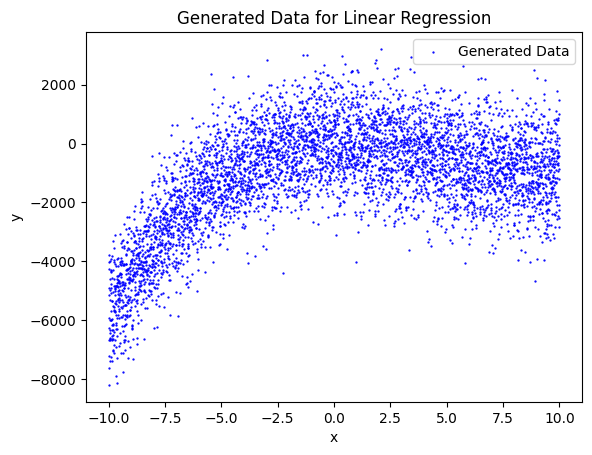

In [3]:
# 设置随机种子，确保结果可复现
torch.manual_seed(42)

# 生成数据
a = 2.5
b = -34.1
c = 3
x = torch.linspace(-10, 10, 5000).view(-1, 1)  # 生成100个点的输入数据
y = a * (x ** 3) + b * (x **2) + c + torch.randn_like(x) * 1100  # 加入一点噪声，模拟真实场景中的数据
plt.scatter(x.numpy(), y.numpy(),s=.4, color='blue', label='Generated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data for Linear Regression')
plt.legend()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# 将数据划分为训练集和验证集
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# 转换为PyTorch的Tensor
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)  # 转换为二维Tensor
x_val = torch.tensor(x_val, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

/tmp/ipykernel_126137/1722077098.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)  # 转换为二维Tensor
/tmp/ipykernel_126137/1722077098.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_126137/1722077098.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_126137/1722077098.py:10: UserWarning: To copy construct from a tenso

In [5]:
# 定义神经网络模型
class QuadraticModel(nn.Module):
    def __init__(self):
        super(QuadraticModel, self).__init__()
        # 输入层 -> 隐藏层（64个神经元）
        self.fc1 = nn.Linear(1, 32)  # 输入 1维 (x)，输出 64维
        self.fc2 = nn.Linear(32, 1)  # 输出 1维 (y)
        self.relu = nn.ReLU()  # 使用 ReLU 激活函数

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建模型实例
model = QuadraticModel()

# 查看模型结构
print(model)

QuadraticModel(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# 设置超参数
num_epochs = 50000
patience = 100  
best_val_loss = float('inf')
patience_counter = 0  

criterion = nn.MSELoss()  # 用于回归任务
# criterion = nn.CrossEntropyLoss()  # 用于分类任务
# 使用 Adam 优化器和学习率调度器
optimizer = optim.Adam(model.parameters(), lr=0.02)  # Adam 适用于非凸优化
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # 前向传播
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    train_losses.append(loss.item())
    
    # 反向传播
    loss.backward()
    optimizer.step()

    # 每 500 轮进行验证
    if epoch % 500 == 0:
        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = criterion(y_val_pred, y_val)
            val_losses.append(val_loss.item())

        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}", end='\r')

        # 更新学习率（如果验证损失没有改善）
        scheduler.step(val_loss)

        # Early Stopping 机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# 最终评估
model.eval()
with torch.no_grad():
    y_val_pred = model(x_val)
    val_loss = criterion(y_val_pred, y_val)
print(f"Final Validation Loss: {val_loss.item():.4f}")

Final Validation Loss: 1226000.0000 1204359.2500, Validation Loss: 1226000.0000


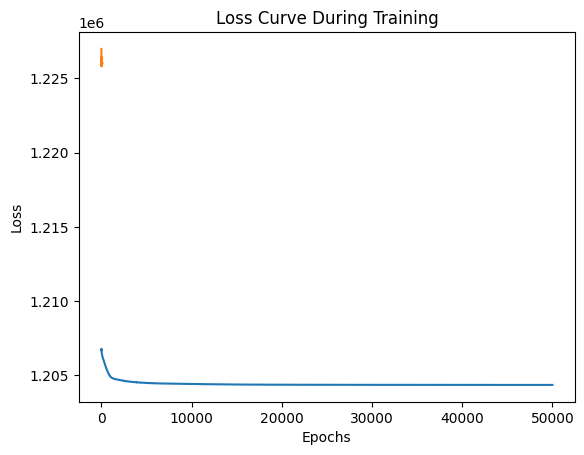

In [9]:
# 绘制损失曲线
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve During Training')
plt.show()

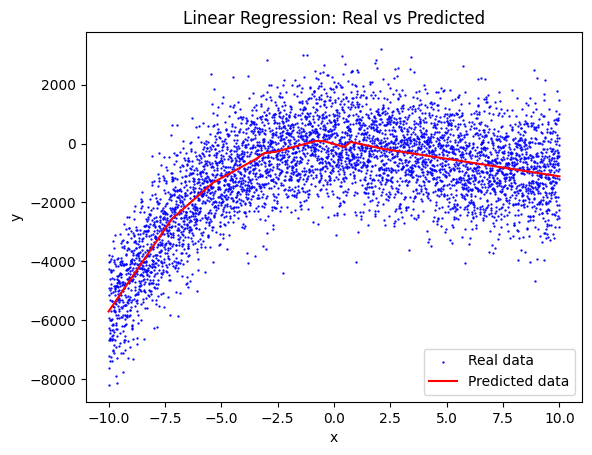

In [10]:
# 使用训练好的模型进行预测
with torch.no_grad():  # 在预测时不需要计算梯度
    predicted = model(x)

# 绘制真实数据和预测数据
plt.scatter(x.numpy(), y.numpy(),s=.4, label='Real data', color='blue')
plt.plot(x.numpy(), predicted.numpy(), label='Predicted data', color='red')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression: Real vs Predicted')
plt.show()